Info    : Reading 'convergence/geometry05.msh'...
Info    : 26 entities
Info    : 3275 nodes
Info    : 6552 elements
Info    : Done reading 'convergence/geometry05.msh'


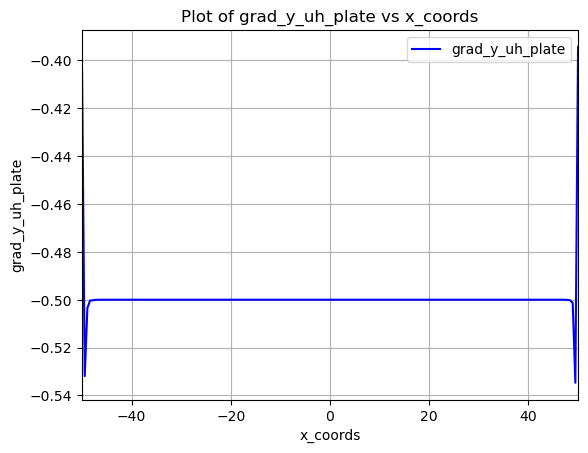

In [ ]:
# LAPLACE EQUATION WITH DIRICHLET BOUNDARY CONDITIONS

# read a mesh from file capacitor.msh
from mpi4py import MPI
from dolfinx.io import gmshio
domain, cell_tags, facet_tags = gmshio.read_from_msh("convergence/geometry04.msh", MPI.COMM_WORLD, 0, gdim=2)


# define finite element function space
from dolfinx.fem import functionspace
import numpy as np
V = functionspace(domain, ("Lagrange", 1))

# identify the boundary (create facet to cell connectivity required to determine boundary facets)
from dolfinx import default_scalar_type
from dolfinx.fem import (Constant, dirichletbc, locate_dofs_topological)
from dolfinx.fem.petsc import LinearProblem
tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(fdim, tdim)

# Find facets marked with 2 and 3 (the two rectangles)
facets_rect1 = np.concatenate([facet_tags.find(10), facet_tags.find(11)])
facets_rect2 = facet_tags.find(12)

# Locate degrees of freedom
dofs_rect1 = locate_dofs_topological(V, fdim, facets_rect1)
dofs_rect2 = locate_dofs_topological(V, fdim, facets_rect2)

# Define different Dirichlet values
u_rect1 = Constant(domain, 0.0)
u_rect2 = Constant(domain, 1.0)

# Create BCs
bc1 = dirichletbc(u_rect1, dofs_rect1, V)
bc2 = dirichletbc(u_rect2, dofs_rect2, V)

bcs = [bc1, bc2]

# trial and test functions
import ufl
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

# source term
from dolfinx import default_scalar_type
from dolfinx import fem
f = fem.Constant(domain, default_scalar_type(0.0))

# variational problem
a = ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = f * v * ufl.dx

# assemble the system
from dolfinx.fem.petsc import LinearProblem
problem = LinearProblem(a, L, bcs=bcs, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()



# APPROXIMATION OF THE GRADIENT OF THE SOLUTION

import ufl

# Define the vector function space for the gradient
V_vec = fem.functionspace(domain, ("Lagrange", 1, (domain.geometry.dim, )))

# Define the trial and test functions for the vector space
u_vec = ufl.TrialFunction(V_vec)
v_vec = ufl.TestFunction(V_vec)

# Define the gradient of the solution
grad_u = ufl.grad(uh)

# Define the bilinear and linear forms
a_grad = ufl.inner(u_vec, v_vec) * ufl.dx
L_grad = ufl.inner(grad_u, v_vec) * ufl.dx

# Assemble the system
from dolfinx.fem.petsc import LinearProblem
problem_grad = LinearProblem(a_grad, L_grad, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
grad_uh = problem_grad.solve()


# PLOTTING THE GRADIENT OF THE SOLUTION ON THE UPPER PLATE

# Step 1: Find facets with tag 10
facets10 = facet_tags.find(10)
dofs10 = locate_dofs_topological(V, fdim, facets10)

# Step 2: Extract the x-coordinates and the y-coordinates of the DOFs
x_dofs = V.tabulate_dof_coordinates()[dofs10]
x_coords = x_dofs[:, 0]
y_coords = x_dofs[:, 1]

# Step 3: Evaluate grad_uh at those DOFs
dim = domain.geometry.dim
grad_x_uh_values = grad_uh.x.array[0::dim]
grad_y_uh_values = grad_uh.x.array[1::dim]
grad_x_uh_plate = grad_x_uh_values[dofs10]
grad_y_uh_plate = grad_y_uh_values[dofs10]


import matplotlib.pyplot as plt
# Plot grad_y_uh_plate against x_coords

# Sort x_coords and apply the same ordering to grad_y_uh_plate
sorted_indices = np.argsort(x_coords)
x_coords = x_coords[sorted_indices]
grad_y_uh_plate = grad_y_uh_plate[sorted_indices]
plt.plot(x_coords, grad_y_uh_plate, label="grad_y_uh_plate", color="blue", linestyle="-")
plt.xlim(-50, 50)
plt.xlabel("x_coords")
plt.ylabel("grad_y_uh_plate")
plt.title("Plot of grad_y_uh_plate vs x_coords")
plt.legend()
plt.grid(True)
plt.show()


In [44]:
import pyvista
pyvista.OFF_SCREEN = False
print(pyvista.global_theme.jupyter_backend)

from dolfinx import plot
pyvista.start_xvfb()
domain.topology.create_connectivity(tdim, tdim)

# plot the solution
u_topology, u_cell_types, u_geometry = plot.vtk_mesh(V)
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = uh.x.array.real
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=False, cmap="bwr")
u_plotter.view_xy()
if not pyvista.OFF_SCREEN:
    u_plotter.show()

trame


Widget(value='<iframe src="http://localhost:32963/index.html?ui=P_0x7fc2e392cb20_28&reconnect=auto" class="pyv…

In [45]:
# plot the x component of the gradient
u_topology, u_cell_types, u_geometry = plot.vtk_mesh(V)
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = grad_x_uh_values.real
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=False, cmap="bwr")
u_plotter.view_xy()
if not pyvista.OFF_SCREEN:
    u_plotter.show()

Widget(value='<iframe src="http://localhost:32963/index.html?ui=P_0x7fc2d8cae770_29&reconnect=auto" class="pyv…

In [46]:
# plot the y component of the gradient
u_topology, u_cell_types, u_geometry = plot.vtk_mesh(V)
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = grad_y_uh_values.real
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=False, cmap="bwr")
u_plotter.view_xy()
if not pyvista.OFF_SCREEN:
    u_plotter.show()

Widget(value='<iframe src="http://localhost:32963/index.html?ui=P_0x7fc2bdfefc40_30&reconnect=auto" class="pyv…